In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM,Embedding,InputLayer,Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import re
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MERAL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MERAL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [162]:
data= pd.read_csv("labeled_data.csv")

In [163]:
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [164]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('<.*?>+', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('rt', '', text)
    text = re.sub('\d', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('  ', ' ', text)
    
    return text

data['tweet'] = data['tweet'].apply(clean_text)
data['tweet'].head(10)

0     mayasolovely as a woman you shouldnt complain...
1     mleew boy dats coldtyga dwn bad for cuffin da...
2     urkindofbrand dawg sbabylife you ever fuck a ...
3          cganderson vivabased she look like a tranny
4     shenikarobes the shit you hear about me might...
5    tmadisonx the shit just blows meclaim you so f...
6    brighterdays i can not just sit up and hate on...
7    selfiequeenbri cause im tired of you big bitch...
8     amp you might not get ya bitch back amp thats...
9     rhythmixx hobbies include fighting mariam\n\n...
Name: tweet, dtype: object

In [165]:
sw = set(stopwords.words("english"))

def remove_stopwords(text):
    tokens = word_tokenize(text)
    cleaned_tokens = [word for word in tokens if word.lower() not in sw]
    return " ".join(cleaned_tokens)


data['tweet'] = data['tweet'].apply(remove_stopwords)
data['tweet'].head(10)

0    mayasolovely woman shouldnt complain cleaning ...
1    mleew boy dats coldtyga dwn bad cuffin dat hoe...
2    urkindofbrand dawg sbabylife ever fuck bitch s...
3                cganderson vivabased look like tranny
4    shenikarobes shit hear might true might faker ...
5    tmadisonx shit blows meclaim faithful somebody...
6    brighterdays sit hate another bitch got much s...
7    selfiequeenbri cause im tired big bitches comi...
8                amp might get ya bitch back amp thats
9      rhythmixx hobbies include fighting mariam bitch
Name: tweet, dtype: object

In [166]:
text = " ".join(i for i in data['tweet'])

In [167]:
data['sentiment'] = data['class'].map({0:'Hate_Speech',1:'offensive_language',
                                  2: 'Neither'})

In [168]:
x = data['tweet']
y = data['class']

In [169]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=16)

In [170]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [171]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index

In [172]:
max_length = 0
for sequence in x_train:
    sequence_length = len(sequence)
    if sequence_length > max_length:
        max_length = sequence_length
print(max_length)

28


In [181]:
from tensorflow.keras.utils import pad_sequences

x_train = pad_sequences(x_train,maxlen=max_length,padding='post')
x_test = pad_sequences(x_test,maxlen=max_length,padding='post')

In [189]:
%reload_ext tensorboard

In [190]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [191]:
model = Sequential()
model.add(InputLayer(input_shape=(max_length,))) 
model.add(Embedding(len(word_index) + 1, output_dim=28))
model.add((LSTM(300, return_sequences=True)))
model.add((LSTM(300, return_sequences=True)))
model.add((LSTM(300)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)             │ (None, 28, 28)              │         805,924 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 28, 300)             │         394,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 28, 300)             │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_36 (LSTM)                       │ (None, 300)                 │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,644,027 (10.09 MB)

 Trainable params: 2,644,027 (10.09 MB)

 Non-trainable params: 0 (0.00 B)

In [192]:
history = model.fit(x_train,y_train,batch_size=32,epochs=8,validation_split=0.15, callbacks=[tensorboard_callback])

Epoch 1/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 398s 736ms/step - accuracy: 0.8091 - loss: 0.5389 - val_accuracy: 0.8675 - val_loss: 0.3675
Epoch 2/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 379s 720ms/step - accuracy: 0.9169 - loss: 0.2837 - val_accuracy: 0.8705 - val_loss: 0.3904
Epoch 3/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 358s 679ms/step - accuracy: 0.9311 - loss: 0.2199 - val_accuracy: 0.8722 - val_loss: 0.4315
Epoch 4/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 154s 292ms/step - accuracy: 0.9443 - loss: 0.1838 - val_accuracy: 0.8594 - val_loss: 0.4344
Epoch 5/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 155s 294ms/step - accuracy: 0.9510 - loss: 0.1673 - val_accuracy: 0.8356 - val_loss: 0.4773
Epoch 6/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 159s 302ms/step - accuracy: 0.9595 - loss: 0.1342 - val_accuracy: 0.8584 - val_loss: 0.5260
Epoch 7/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 151s 286ms/step - accuracy: 0.9782 - loss: 0.0830 - val_accuracy: 0.8561 - val_loss: 0.5992
Epoch 8/8
527/527 ━━━━━━━━━━━━━━━━━━━━ 184s 349ms/step - accuracy: 0.9842 - loss: 0

In [193]:
results = model.evaluate(x_test,y_test)
pred = model.predict(x_test)
print(results)
print("Max Accuracy: ",max(history.history['accuracy']))
print("Max vallidation accuracy: ",max(history.history['val_accuracy']))

155/155 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8505 - loss: 0.6753
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step
[0.6453104615211487, 0.8573734164237976]
Max Accuracy:  0.984512209892273
Max vallidation accuracy:  0.8722259402275085


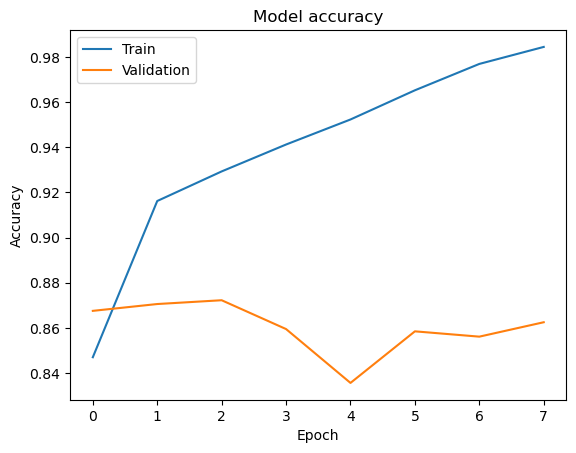

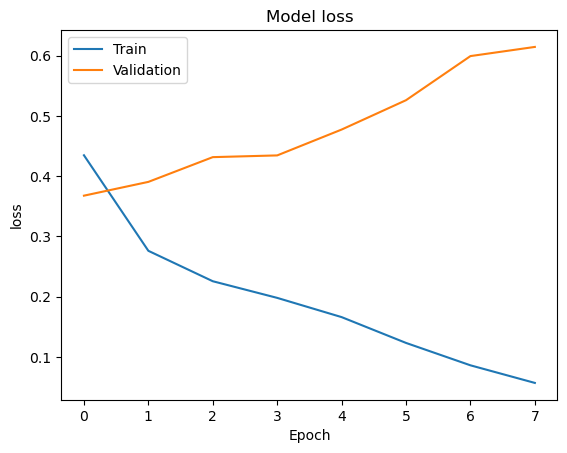

In [194]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#training and evaluation resluts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [195]:
%tensorboard --logdir logs/fit